In [2]:
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import glob
from pyPRISMClimate import get_prism_monthlys, get_prism_monthly_single
import pandas as pd
import datetime as dt
from pysheds.grid import Grid
import numpy as np
import fiona
import scipy.stats as stats
# import resampling from rasterio
from rasterio.enums import Resampling

# Precipitation Data

### Get Bains Boundary

In [3]:
ucrb_boundary = gpd.read_file(".\\data\\basin_polygons\\Upper_Colorado_River_Basin_Boundary.json", driver="GeoJSON")

### PRISM temperature and precipitation

In [4]:
# Get monthly mean temperature
# check if the length of ./data/PRISM/temperature/ is < 120
# if so, download the missing files
# if not, do nothing
if len(glob.glob(".\\data\\PRISM\\temperature\\*.bil")) < 15:
    get_prism_monthlys(variable='tmean', years=[2016,2017,2018,2019,2020], months=[3,4,5], dest_path='./data/PRISM/temperature/')
else:
    # Download historic PRISM precipitation from 4km product 
    if not os.path.exists(".\\data\\PRISM\\temperature\\prism_4km_ucrb_temperature.nc"):
       filelist = glob.glob(".\\data\\PRISM\\temperature\\*.bil")
       prism_list = []
       dates = []
       for file in filelist:
              dates.append(file[-14:-8]+'01')
              tmp = rxr.open_rasterio(file).rio.clip(ucrb_boundary.geometry)
              prism_list.append(tmp)
       prism_4km_tmean = xr.concat(prism_list, dim='band', join='override')
       prism_4km_tmean = prism_4km_tmean.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_tmean = prism_4km_tmean.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 
       prism_4km_tmean = prism_4km_tmean.sortby('month')
       prism_4km_tmean.to_netcdf(".\\data\\PRISM\\temperature\\prism_4km_ucrb_temperature.nc")
    else:
       prism_4km_tmean = xr.open_dataset(".\\data\\PRISM\\temperature\\prism_4km_ucrb_temperature.nc")
       prism_4km_tmean = prism_4km_tmean.rename({'__xarray_dataarray_variable__':'tmean'})

In [5]:
# Get monthly mean precipitation
# check if the length of ./data/PRISM/precipitation/ is < 120
# if so, download the missing files
# if not, do nothing
if len(glob.glob(".\\data\\PRISM\\precipitation\\*.bil")) < 15:
    get_prism_monthlys(variable='ppt', years=[2016,2017,2018,2019,2020], months=[3,4,5], dest_path='./data/PRISM/precipitation/')
else:
    # Download historic PRISM precipitation from 4km product 
    if not os.path.exists(".\\data\\PRISM\\precipitation\\prism_4km_ucrb_precipitation.nc"):
       filelist = glob.glob(".\\data\\PRISM\\precipitation\\*.bil")
       prism_list = []
       dates = []
       for file in filelist:
              dates.append(file[-14:-8]+'01')
              tmp = rxr.open_rasterio(file).rio.clip(ucrb_boundary.geometry)
              prism_list.append(tmp)
       prism_4km_ppt = xr.concat(prism_list, dim='band', join='override')
       prism_4km_ppt = prism_4km_ppt.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_ppt = prism_4km_ppt.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 
       prism_4km_ppt = prism_4km_ppt.sortby('month')
       prism_4km_ppt.to_netcdf(".\\data\\PRISM\\precipitation\\prism_4km_ucrb_precipitation.nc")
    else:
       prism_4km_ppt = xr.open_dataset(".\\data\\PRISM\\precipitation\\prism_4km_ucrb_precipitation.nc")
       # rename __xarray_dataarray_variable__ to ppt
       prism_4km_ppt = prism_4km_ppt.rename({'__xarray_dataarray_variable__':'ppt'})

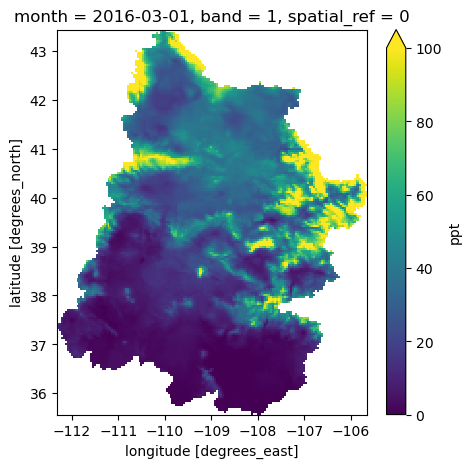

In [627]:
prism_4km_ppt.sel(month='2016-03-01').ppt.plot(figsize=(5, 5), vmin=0, vmax=100, cmap='viridis')

### Get IMERG precipitation

In [87]:
# open one imerg file
if not os.path.exists(".\\data\\IMERG\\IMERG_Monthly_Precipitation_2016_2020.nc"):
    filelist = glob.glob(".\\data\\IMERG\\*.tif")
    imerg_list = []
    dates = []
    for file in filelist:
        dates.append(file[-14:-4])
        tmp = rxr.open_rasterio(file).rio.clip(ucrb_boundary.geometry)
        imerg_list.append(tmp)
    imerg = xr.concat(imerg_list, dim='band', join='override')
    imerg = imerg.rename({'band':'month'})
    imerg = imerg.assign_coords({
        'month': pd.to_datetime(dates,format='%Y-%m-%d')})
    imerg = imerg.sortby('month')
    imerg.to_netcdf(".\\data\\IMERG\\IMERG_Monthly_Precipitation_2016_2020.nc")
else:
    imerg = xr.open_dataset(".\\data\\IMERG\\IMERG_Monthly_Precipitation_2016_2020.nc")
    # rename __xarray_dataarray_variable__ to ppt
    imerg = imerg.rename({'__xarray_dataarray_variable__':'ppt'})
    

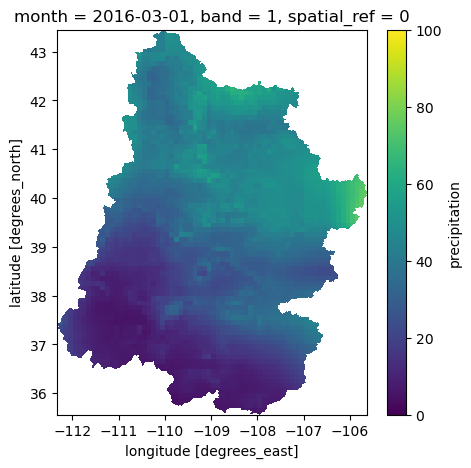

In [628]:
imerg.sel(month='2016-03-01').ppt.plot(figsize=(5, 5), vmin=0, vmax=100, cmap='viridis')

# Plot IMERG - PRISM relationships by month during spring

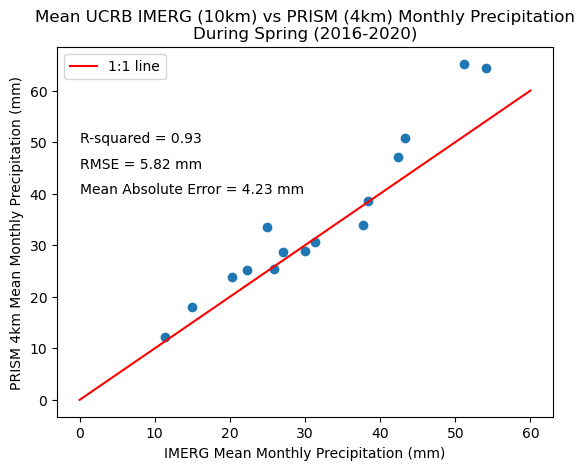

In [113]:
# plot UCRB mean ppt vs IMERG mean ppt
plt.scatter(imerg.ppt.mean(dim=['x','y']),
            prism_4km_ppt.ppt.mean(dim=['x','y']))
plt.xlabel('IMERG Mean Monthly Precipitation (mm)')
plt.ylabel('PRISM 4km Mean Monthly Precipitation (mm)')
# add 1:1 line
x = np.linspace(0, 60, 70)
plt.plot(x, x, '-r', label='1:1 line')
plt.title('Mean UCRB IMERG (10km) vs PRISM (4km) Monthly Precipitation\nDuring Spring (2016-2020)')
# add r-squared
slope, intercept, r_value, p_value, std_err = stats.linregress(imerg.ppt.mean(dim=['x','y']), prism_4km_ppt.ppt.mean(dim=['x','y']))
# print the mean absolute error
mse = np.mean(np.abs(imerg.ppt.mean(dim=['x','y']) - prism_4km_ppt.ppt.mean(dim=['x','y'])))
# calculate the root mean square error
rmse = np.sqrt(np.mean((imerg.ppt.mean(dim=['x','y']) - prism_4km_ppt.ppt.mean(dim=['x','y']))**2))
plt.text(0, 50, 'R-squared = %0.2f' % r_value**2)
plt.text(0, 45, 'RMSE = %0.2f mm' % rmse)
plt.text(0, 40, 'Mean Absolute Error = %0.2f mm' % mse)
plt.legend()


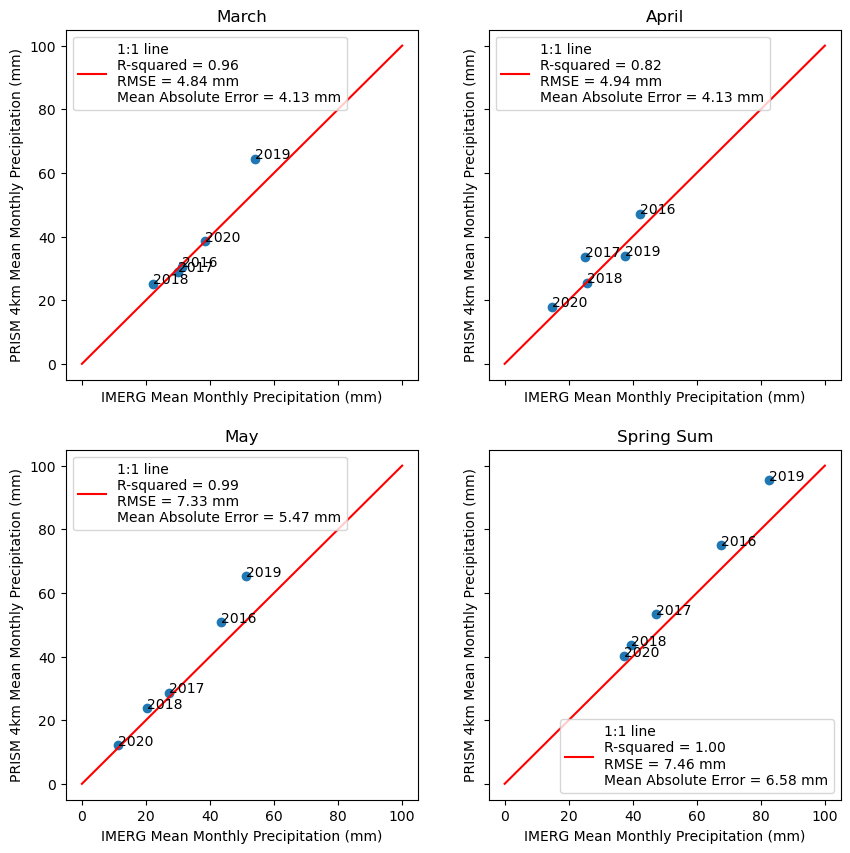

In [640]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
# plot UCRB mean ppt vs IMERG mean ppt for march
ax[0,0].scatter(imerg.ppt.where(imerg.month.dt.month==3,drop=True).mean(dim=['x','y']),
            prism_4km_ppt.ppt.where(prism_4km_ppt.month.dt.month==3,drop=True).mean(dim=['x','y']))
# add 1:1 line
x = np.linspace(0,100,10)
# add r-squared
slope, intercept, r_value, p_value, std_err = stats.linregress(imerg.ppt.where(imerg.month.dt.month==3,drop=True).mean(dim=['x','y']), prism_4km_ppt.ppt.where(prism_4km_ppt.month.dt.month==3,drop=True).mean(dim=['x','y']))
# print the mean absolute error
mae = np.mean(np.abs(imerg.ppt.where(imerg.month.dt.month==3,drop=True).mean(dim=['x','y']) - prism_4km_ppt.ppt.where(prism_4km_ppt.month.dt.month==3,drop=True).mean(dim=['x','y'])))
# calculate the root mean square error
rmse = np.sqrt(np.mean((imerg.ppt.where(imerg.month.dt.month==3,drop=True).mean(dim=['x','y']) - prism_4km_ppt.ppt.where(prism_4km_ppt.month.dt.month==3,drop=True).mean(dim=['x','y']))**2))

ax[0,0].plot(x, x, '-r', label='1:1 line\nR-squared = %0.2f\nRMSE = %0.2f mm\nMean Absolute Error = %0.2f mm' % (r_value**2, rmse, mse))
# label each year
for i, txt in enumerate(imerg.ppt.where(imerg.month.dt.month==3,drop=True).groupby('month.year').mean(dim=['x','y']).month.dt.year.values):
    ax[0,0].annotate(txt, (imerg.ppt.where(imerg.month.dt.month==3,drop=True).mean(dim=['x','y']).values[i], 
                            prism_4km_ppt.ppt.where(prism_4km_ppt.month.dt.month==3,drop=True).mean(dim=['x','y']).values[i]))
ax[0,0].set_title('March')
ax[0,0].set_xlabel('IMERG Mean Monthly Precipitation (mm)')
ax[0,0].set_ylabel('PRISM 4km Mean Monthly Precipitation (mm)')
ax[0,0].legend()

# plot UCRB mean ppt vs IMERG mean ppt for april
ax[0,1].scatter(imerg.ppt.where(imerg.month.dt.month==4,drop=True).mean(dim=['x','y']),
            prism_4km_ppt.ppt.where(prism_4km_ppt.month.dt.month==4,drop=True).mean(dim=['x','y']))
for i, txt in enumerate(imerg.ppt.where(imerg.month.dt.month==4,drop=True).groupby('month.year').mean(dim=['x','y']).month.dt.year.values):
    ax[0,1].annotate(txt, (imerg.ppt.where(imerg.month.dt.month==4,drop=True).mean(dim=['x','y']).values[i], 
                            prism_4km_ppt.ppt.where(prism_4km_ppt.month.dt.month==4,drop=True).mean(dim=['x','y']).values[i]))
ax[0,1].set_title('April')
ax[0,1].set_xlabel('IMERG Mean Monthly Precipitation (mm)')
ax[0,1].set_ylabel('PRISM 4km Mean Monthly Precipitation (mm)')
# add r-squared
slope, intercept, r_value, p_value, std_err = stats.linregress(imerg.ppt.where(imerg.month.dt.month==4,drop=True).mean(dim=['x','y']), prism_4km_ppt.ppt.where(prism_4km_ppt.month.dt.month==4,drop=True).mean(dim=['x','y']))
# print the mean absolute error
mse = np.mean(np.abs(imerg.ppt.where(imerg.month.dt.month==4,drop=True).mean(dim=['x','y']) - prism_4km_ppt.ppt.where(prism_4km_ppt.month.dt.month==4,drop=True).mean(dim=['x','y'])))
# calculate the root mean square error
rmse = np.sqrt(np.mean((imerg.ppt.where(imerg.month.dt.month==4,drop=True).mean(dim=['x','y']) - prism_4km_ppt.ppt.where(prism_4km_ppt.month.dt.month==4,drop=True).mean(dim=['x','y']))**2))
ax[0,1].plot(x, x, '-r', label='1:1 line\nR-squared = %0.2f\nRMSE = %0.2f mm\nMean Absolute Error = %0.2f mm' % (r_value**2, rmse, mse))
ax[0,1].legend()

# plot UCRB mean ppt vs IMERG mean ppt for may
ax[1,0].scatter(imerg.ppt.where(imerg.month.dt.month==5,drop=True).mean(dim=['x','y']),
            prism_4km_ppt.ppt.where(prism_4km_ppt.month.dt.month==5,drop=True).mean(dim=['x','y']))
for i, txt in enumerate(imerg.ppt.where(imerg.month.dt.month==5,drop=True).groupby('month.year').mean(dim=['x','y']).month.dt.year.values):
    ax[1,0].annotate(txt, (imerg.ppt.where(imerg.month.dt.month==5,drop=True).mean(dim=['x','y']).values[i], 
                            prism_4km_ppt.ppt.where(prism_4km_ppt.month.dt.month==5,drop=True).mean(dim=['x','y']).values[i]))
ax[1,0].set_title('May')
ax[1,0].set_xlabel('IMERG Mean Monthly Precipitation (mm)')
ax[1,0].set_ylabel('PRISM 4km Mean Monthly Precipitation (mm)')
# add r-squared
slope, intercept, r_value, p_value, std_err = stats.linregress(imerg.ppt.where(imerg.month.dt.month==5,drop=True).mean(dim=['x','y']), 
                                                               prism_4km_ppt.ppt.where(prism_4km_ppt.month.dt.month==5,drop=True).mean(dim=['x','y']))
# print the mean absolute error
mae = np.mean(np.abs(imerg.ppt.where(imerg.month.dt.month==5,drop=True).mean(dim=['x','y']) - prism_4km_ppt.ppt.where(prism_4km_ppt.month.dt.month==5,drop=True).mean(dim=['x','y'])))
# calculate the root mean square error
rmse = np.sqrt(np.mean((imerg.ppt.where(imerg.month.dt.month==5,drop=True).mean(dim=['x','y']) - prism_4km_ppt.ppt.where(prism_4km_ppt.month.dt.month==5,drop=True).mean(dim=['x','y']))**2))
ax[1,0].plot(x, x, '-r', label='1:1 line\nR-squared = %0.2f\nRMSE = %0.2f mm\nMean Absolute Error = %0.2f mm' % (r_value**2, rmse, mae))
ax[1,0].legend()

# plot UCRB mean ppt vs IMERG mean ppt for spring sum
ax[1,1].scatter(imerg.ppt.groupby('month.year').sum(dim='month').mean(dim=['x','y']),
            prism_4km_ppt.ppt.groupby('month.year').sum(dim='month').mean(dim=['x','y']))
for i, txt in enumerate(imerg.ppt.groupby('month.year').sum(dim='month').mean(dim=['x','y']).year.values):
    ax[1,1].annotate(txt, (imerg.ppt.groupby('month.year').sum(dim='month').mean(dim=['x','y']).values[i], 
                            prism_4km_ppt.ppt.groupby('month.year').sum(dim='month').mean(dim=['x','y']).values[i]))
# add 1:1 line
x = np.linspace(0,100,10)

ax[1,1].set_title('Spring Sum')
ax[1,1].set_xlabel('IMERG Mean Monthly Precipitation (mm)')
ax[1,1].set_ylabel('PRISM 4km Mean Monthly Precipitation (mm)')
# add r-squared
slope, intercept, r_value, p_value, std_err = stats.linregress(imerg.ppt.groupby('month.year').sum(dim='month').mean(dim=['x','y']), prism_4km_ppt.ppt.groupby('month.year').sum(dim='month').mean(dim=['x','y']))
# print the mean absolute error
mae = np.mean(np.abs(imerg.ppt.groupby('month.year').sum(dim='month').mean(dim=['x','y']) - prism_4km_ppt.ppt.groupby('month.year').sum(dim='month').mean(dim=['x','y'])))
# calculate the root mean square error
rmse = np.sqrt(np.mean((imerg.ppt.groupby('month.year').sum(dim='month').mean(dim=['x','y']) - prism_4km_ppt.ppt.groupby('month.year').sum(dim='month').mean(dim=['x','y']))**2))

ax[1,1].plot(x, x, '-r', label='1:1 line\nR-squared = %0.2f\nRMSE = %0.2f mm\nMean Absolute Error = %0.2f mm' % (r_value**2, rmse, mae))
ax[1,1].legend()

Text(4.2, 10, 'Spring Sum')

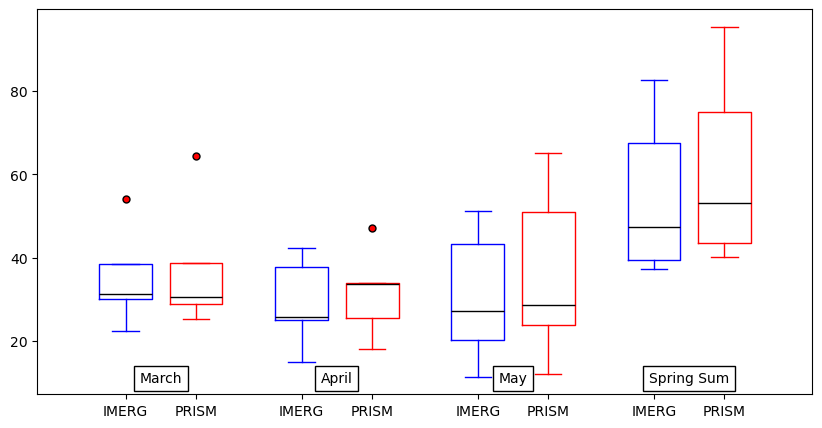

In [663]:
# plot boxplot for each month and spring sum
fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot([imerg.ppt.where(imerg.month.dt.month==3,drop=True).mean(dim=['x','y']).values,
            imerg.ppt.where(imerg.month.dt.month==4,drop=True).mean(dim=['x','y']).values,
            imerg.ppt.where(imerg.month.dt.month==5,drop=True).mean(dim=['x','y']).values,
            imerg.ppt.groupby('month.year').sum(dim='month').mean(dim=['x','y']).values],
           positions=[1,2,3,4],
           # set the box width to 0.3
              widths=0.3,
           # make outline blue and median black
           boxprops=dict(color='blue'),
              medianprops=dict(color='black'),
                whiskerprops=dict(color='blue'),
                capprops=dict(color='blue'),
                flierprops=dict(markerfacecolor='r', marker='o', markersize=5),
                labels=['IMERG','IMERG', 'IMERG', 'IMERG']);
ax.boxplot([prism_4km_ppt.ppt.where(prism_4km_ppt.month.dt.month==3,drop=True).mean(dim=['x','y']).values,
            prism_4km_ppt.ppt.where(prism_4km_ppt.month.dt.month==4,drop=True).mean(dim=['x','y']).values,
            prism_4km_ppt.ppt.where(prism_4km_ppt.month.dt.month==5,drop=True).mean(dim=['x','y']).values,
            prism_4km_ppt.ppt.groupby('month.year').sum(dim='month').mean(dim=['x','y']).values],
            positions=[1.4,2.4,3.4,4.4],
            widths=0.3,
           # make outline blue and median black
           boxprops=dict(color='red'),
              medianprops=dict(color='black'),
                whiskerprops=dict(color='red'),
                capprops=dict(color='red'),
                flierprops=dict(markerfacecolor='r', marker='o', markersize=5),
                labels=['PRISM','PRISM', 'PRISM', 'PRISM']);
# add an annotation in a white box over each set of boxes located at 1.2, 2.2, 3.2, and 4.2
ax.text(1.2, 10, 'March', color='black', bbox=dict(facecolor='white', alpha=1, edgecolor='black'), ha='center')
ax.text(2.2, 10, 'April', color='black', bbox=dict(facecolor='white', alpha=1, edgecolor='black'), ha='center')
ax.text(3.2, 10, 'May', color='black', bbox=dict(facecolor='white', alpha=1, edgecolor='black'), ha='center')
ax.text(4.2, 10, 'Spring Sum', color='black', bbox=dict(facecolor='white', alpha=1, edgecolor='black'), ha='center')

# Plot IMERG and PRISM with elevation

### Grab DEM and resample for PRISM and IMERG

In [670]:
dem_rxr_32613 = rxr.open_rasterio('./data/basin_polygons/ucrb_dem_32613_150m.tif')
# resample dem to 10km
dem_rxr_10km = dem_rxr_32613.rio.reproject(4326)
# reproject match to imerg
imerg = imerg.rio.write_crs(4326)
dem_rxr_10km = dem_rxr_10km.rio.reproject_match(imerg, resampling=Resampling.nearest)
# resample dem to 4km
dem_rxr_4km = dem_rxr_32613.rio.reproject(4326)
# reproject match to imerg
prism_4km_ppt = prism_4km_ppt.rio.write_crs(4326)
dem_rxr_4km = dem_rxr_4km.rio.reproject_match(prism_4km_ppt, resampling=Resampling.nearest)
# reproject match prism 4km to imerg
prism_10km_ppt = prism_4km_ppt.rio.reproject_match(imerg, resampling=Resampling.nearest)
# convert to 4326
dem_rxr = dem_rxr_32613.rio.reproject(4326)
# save the dem to tif
dem_rxr.rio.to_raster('./data/basin_polygons/ucrb_dem_150m_4326.tif')
# resample dem to 10km


In [671]:
# add these elevation bands to imerg and prism
imerg['elevation'] = dem_rxr_10km.squeeze()
# replace negative values with nan
imerg['elevation'] = imerg['elevation'].where(imerg['elevation'] > 0, np.nan)
prism_4km_ppt['elevation'] = dem_rxr_4km.squeeze()
# replace negative values with nan
prism_4km_ppt['elevation'] = prism_4km_ppt['elevation'].where(prism_4km_ppt['elevation'] > 0, np.nan)
prism_10km_ppt['elevation'] = dem_rxr_10km.squeeze()
# replace negative values with nan
prism_10km_ppt['elevation'] = prism_10km_ppt['elevation'].where(prism_10km_ppt['elevation'] > 0, np.nan)

### Calculation mean by 200 m elevation bands and plot fractional area

In [304]:
# calculate the fractional area for each elevation band
# calculate the area of each pixel
imerg['area'] = (imerg['elevation'])
prism_4km_ppt['area'] = (prism_4km_ppt['elevation'])
prism_10km_ppt['area'] = (prism_10km_ppt['elevation'])
# replace all values with 1
imerg['area'] = imerg['area'].where(imerg['area'] > 0, imerg['elevation'].rio.resolution()[0]**2)
prism_4km_ppt['area'] = prism_4km_ppt['area'].where(prism_4km_ppt['area'] > 0, prism_4km_ppt['elevation'].rio.resolution()[0]**2)
prism_10km_ppt['area'] = prism_10km_ppt['area'].where(prism_10km_ppt['area'] > 0, prism_10km_ppt['elevation'].rio.resolution()[0]**2)
# calculate the total area
total_area = imerg['area'].sum(dim=['x','y'])
# calculate the fractional area
imerg['fractional_area'] = imerg['area'] / total_area
prism_4km_ppt['fractional_area'] = prism_4km_ppt['area'] / total_area
prism_10km_ppt['fractional_area'] = prism_10km_ppt['area'] / total_area


In [318]:
# calculate the mean ppt for each elevation 200 meter elevation band
imerg_elevation_mean = imerg.groupby_bins('elevation', bins=np.arange(prism_4km_ppt.elevation.min(),prism_4km_ppt.elevation.max(),200)).mean()
prism_4km_ppt_elevation_mean = prism_4km_ppt.groupby_bins('elevation', bins=np.arange(prism_4km_ppt.elevation.min(),prism_4km_ppt.elevation.max(),200)).mean()
prism_10km_ppt_elevation_mean = prism_10km_ppt.groupby_bins('elevation', bins=np.arange(prism_4km_ppt.elevation.min(),prism_4km_ppt.elevation.max(),200)).mean()

In [319]:
# calculate the sum ppt for each elevation 200 meter elevation band
imerg_elevation_sum = imerg.groupby_bins('elevation', bins=np.arange(prism_4km_ppt.elevation.min(),prism_4km_ppt.elevation.max(),200)).sum()
prism_4km_ppt_elevation_sum = prism_4km_ppt.groupby_bins('elevation', bins=np.arange(prism_4km_ppt.elevation.min(),prism_4km_ppt.elevation.max(),200)).sum()
prism_10km_ppt_elevation_sum = prism_10km_ppt.groupby_bins('elevation', bins=np.arange(prism_4km_ppt.elevation.min(),prism_4km_ppt.elevation.max(),200)).sum()

Text(0.5, 1.0, 'Fractional Area by Elevation Band')

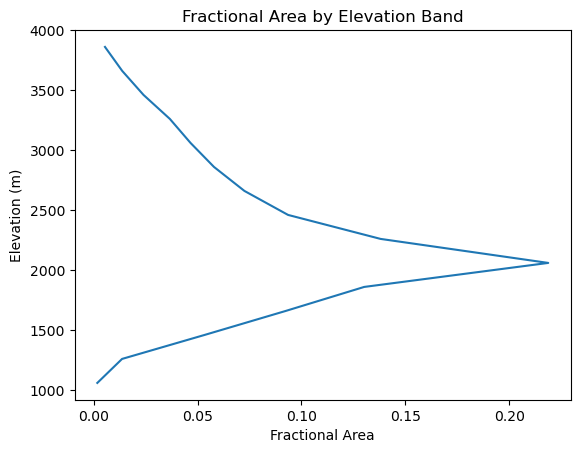

In [320]:
prism_10km_ppt_elevation_sum.fractional_area.plot(y='elevation_bins')
plt.xlabel('Fractional Area')
plt.ylabel('Elevation (m)')
plt.title('Fractional Area by Elevation Band')

# Plot precipitation hypsometry by month

Text(0.5, 1.0, 'Mean Monthly Precipitation vs Elevation for March 2016')

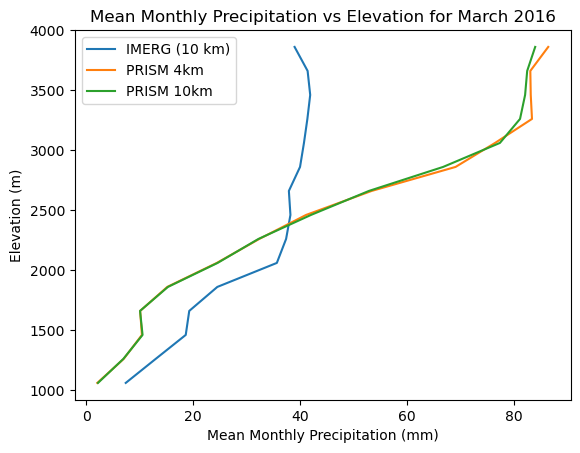

In [335]:
imerg_elevation_mean.ppt.isel(month=0).plot(y='elevation_bins', label='IMERG (10 km)')
prism_4km_ppt_elevation_mean.ppt.isel(month=0).plot(y='elevation_bins', label='PRISM 4km')
prism_10km_ppt_elevation_mean.ppt.isel(month=0).plot(y='elevation_bins', label='PRISM 10km')
plt.legend()
plt.xlabel('Mean Monthly Precipitation (mm)')
plt.ylabel('Elevation (m)')
plt.title('Mean Monthly Precipitation vs Elevation for March 2016')

Text(0, 0.5, 'Elevation (m)')

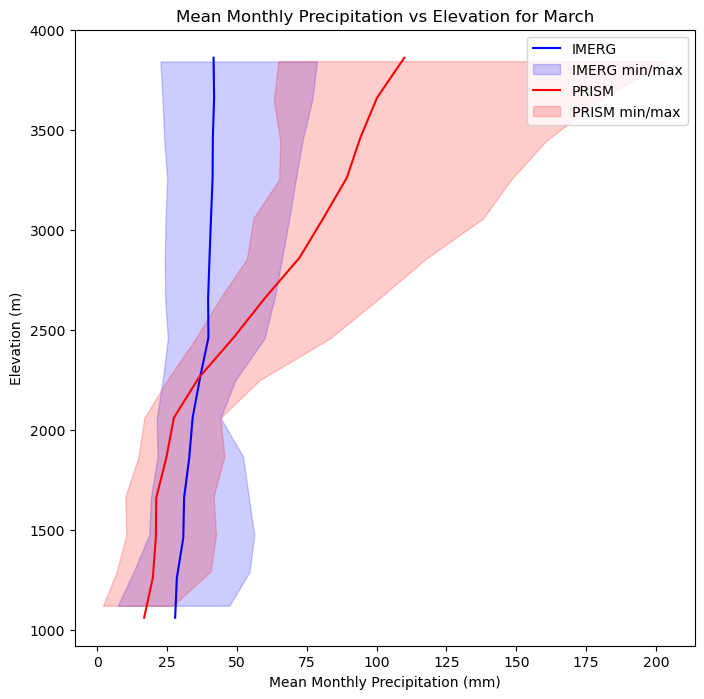

In [336]:
# plot the min, max and mean for each method for march
fig, ax = plt.subplots(figsize=(8, 8))
imerg_elevation_mean.ppt.where(imerg_elevation_mean.month.dt.month==3).mean(dim='month').plot(y='elevation_bins', label='IMERG', color='blue')
ax.fill_betweenx(imerg_elevation_mean.where(imerg_elevation_mean.month.dt.month==3).elevation.sel(month='2016-03-01'),
                imerg_elevation_mean.ppt.where(imerg_elevation_mean.month.dt.month==3).min(dim='month'),
                imerg_elevation_mean.ppt.where(imerg_elevation_mean.month.dt.month==3).max(dim='month'), color='blue', alpha=0.2, label='IMERG min/max')

prism_4km_ppt_elevation_mean.ppt.where(prism_4km_ppt_elevation_mean.month.dt.month==3).mean(dim='month').plot(y='elevation_bins', label='PRISM', color='red')
ax.fill_betweenx(prism_4km_ppt_elevation_mean.where(imerg_elevation_mean.month.dt.month==3).elevation.sel(month='2016-03-01'),
                prism_4km_ppt_elevation_mean.ppt.where(prism_4km_ppt_elevation_mean.month.dt.month==3).min(dim='month'),
                prism_4km_ppt_elevation_mean.ppt.where(prism_4km_ppt_elevation_mean.month.dt.month==3).max(dim='month'), color='red', alpha=0.2, label='PRISM min/max')
ax.legend()
ax.set_title('Mean Monthly Precipitation vs Elevation for March')
ax.set_xlabel('Mean Monthly Precipitation (mm)')
ax.set_ylabel('Elevation (m)')


Text(0, 0.5, 'Elevation (m)')

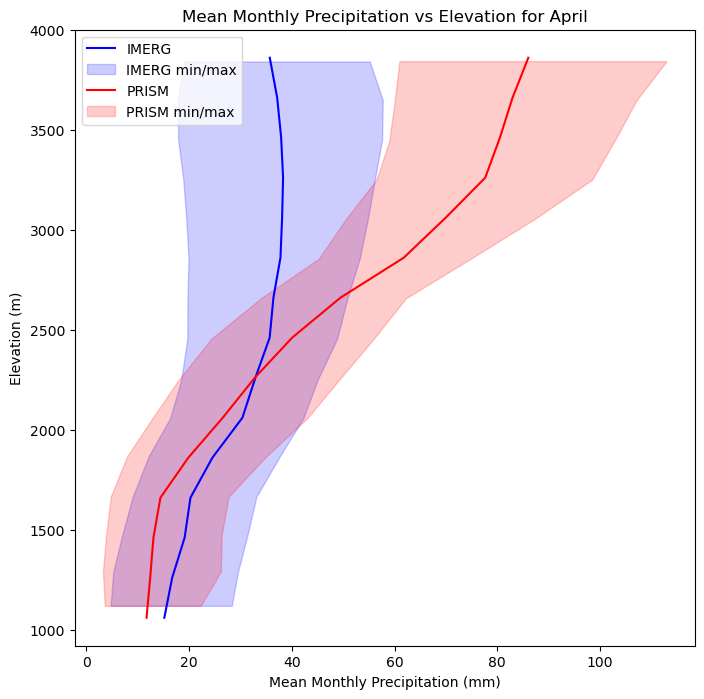

In [337]:
# plot the min, max and mean for each method for march
fig, ax = plt.subplots(figsize=(8, 8))
imerg_elevation_mean.ppt.where(imerg_elevation_mean.month.dt.month==4).mean(dim='month').plot(y='elevation_bins', label='IMERG', color='blue')
ax.fill_betweenx(imerg_elevation_mean.where(imerg_elevation_mean.month.dt.month==4).elevation.sel(month='2016-04-01'),
                imerg_elevation_mean.ppt.where(imerg_elevation_mean.month.dt.month==4).min(dim='month'),
                imerg_elevation_mean.ppt.where(imerg_elevation_mean.month.dt.month==4).max(dim='month'), color='blue', alpha=0.2, label='IMERG min/max')

prism_4km_ppt_elevation_mean.ppt.where(prism_4km_ppt_elevation_mean.month.dt.month==4).mean(dim='month').plot(y='elevation_bins', label='PRISM', color='red')
ax.fill_betweenx(prism_4km_ppt_elevation_mean.where(imerg_elevation_mean.month.dt.month==4).elevation.sel(month='2016-04-01'),
                prism_4km_ppt_elevation_mean.ppt.where(prism_4km_ppt_elevation_mean.month.dt.month==4).min(dim='month'),
                prism_4km_ppt_elevation_mean.ppt.where(prism_4km_ppt_elevation_mean.month.dt.month==4).max(dim='month'), color='red', alpha=0.2, label='PRISM min/max')
ax.legend()
ax.set_title('Mean Monthly Precipitation vs Elevation for April')
ax.set_xlabel('Mean Monthly Precipitation (mm)')
ax.set_ylabel('Elevation (m)')


Text(0, 0.5, 'Elevation (m)')

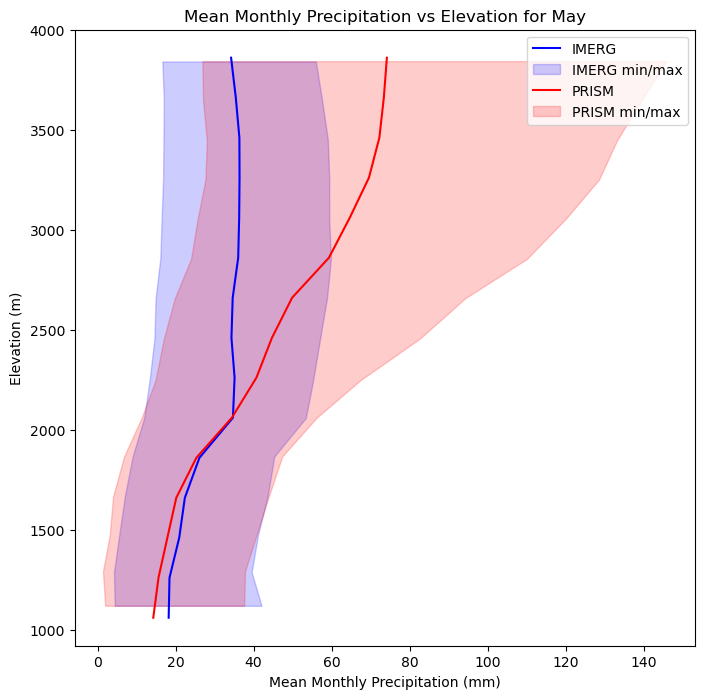

In [338]:
# plot the min, max and mean for each method for march
fig, ax = plt.subplots(figsize=(8, 8))
imerg_elevation_mean.ppt.where(imerg_elevation_mean.month.dt.month==5).mean(dim='month').plot(y='elevation_bins', label='IMERG', color='blue')
ax.fill_betweenx(imerg_elevation_mean.where(imerg_elevation_mean.month.dt.month==5).elevation.sel(month='2016-05-01'),
                imerg_elevation_mean.ppt.where(imerg_elevation_mean.month.dt.month==5).min(dim='month'),
                imerg_elevation_mean.ppt.where(imerg_elevation_mean.month.dt.month==5).max(dim='month'), color='blue', alpha=0.2, label='IMERG min/max')

prism_4km_ppt_elevation_mean.ppt.where(prism_4km_ppt_elevation_mean.month.dt.month==5).mean(dim='month').plot(y='elevation_bins', label='PRISM', color='red')
ax.fill_betweenx(prism_4km_ppt_elevation_mean.where(imerg_elevation_mean.month.dt.month==5).elevation.sel(month='2016-05-01'),
                prism_4km_ppt_elevation_mean.ppt.where(prism_4km_ppt_elevation_mean.month.dt.month==5).min(dim='month'),
                prism_4km_ppt_elevation_mean.ppt.where(prism_4km_ppt_elevation_mean.month.dt.month==5).max(dim='month'), color='red', alpha=0.2, label='PRISM min/max')
ax.legend()
ax.set_title('Mean Monthly Precipitation vs Elevation for May')
ax.set_xlabel('Mean Monthly Precipitation (mm)')
ax.set_ylabel('Elevation (m)')


Text(0, 0.5, 'Elevation (m)')

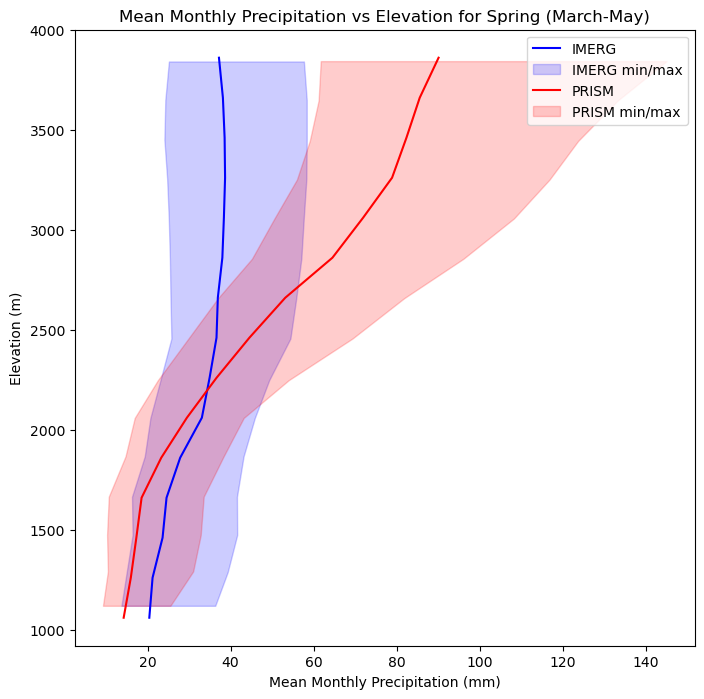

In [339]:
# plot the min, max and mean for each method for march
fig, ax = plt.subplots(figsize=(8, 8))
imerg_elevation_mean.ppt.groupby('month.year').mean().mean(dim='year').plot(y='elevation_bins', label='IMERG', color='blue')
ax.fill_betweenx(imerg_elevation_mean.groupby('month.year').mean().elevation.sel(year=2016),
                 imerg_elevation_mean.ppt.groupby('month.year').mean().min(dim='year'),
                imerg_elevation_mean.ppt.groupby('month.year').mean().max(dim='year'), color='blue', alpha=0.2, label='IMERG min/max')

prism_4km_ppt_elevation_mean.ppt.groupby('month.year').mean().mean(dim='year').plot(y='elevation_bins', label='PRISM', color='red')
ax.fill_betweenx(prism_4km_ppt_elevation_mean.groupby('month.year').mean().elevation.sel(year=2016),
                prism_4km_ppt_elevation_mean.ppt.groupby('month.year').mean().min(dim='year'),
                prism_4km_ppt_elevation_mean.ppt.groupby('month.year').mean().max(dim='year'), color='red', alpha=0.2, label='PRISM min/max')
ax.legend()
ax.set_title('Mean Monthly Precipitation vs Elevation for Spring (March-May)')
ax.set_xlabel('Mean Monthly Precipitation (mm)')
ax.set_ylabel('Elevation (m)')


### Does resampling PRISM to 10km make a difference?

Text(0, 0.5, 'Elevation (m)')

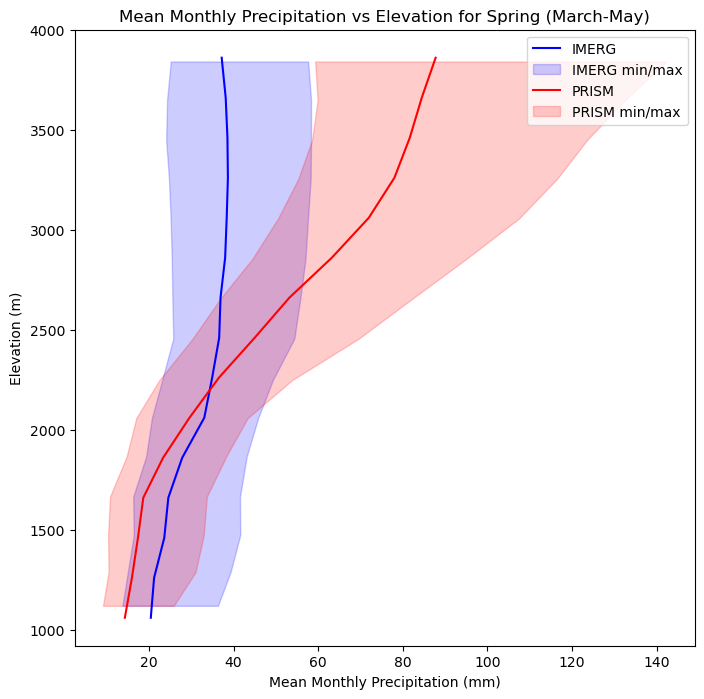

In [340]:
# Does resamplin PRISM make a difference?
# plot the min, max and mean for each method for march
fig, ax = plt.subplots(figsize=(8, 8))
imerg_elevation_mean.ppt.groupby('month.year').mean().mean(dim='year').plot(y='elevation_bins', label='IMERG', color='blue')
ax.fill_betweenx(imerg_elevation_mean.groupby('month.year').mean().elevation.sel(year=2016),
                 imerg_elevation_mean.ppt.groupby('month.year').mean().min(dim='year'),
                imerg_elevation_mean.ppt.groupby('month.year').mean().max(dim='year'), color='blue', alpha=0.2, label='IMERG min/max')

prism_10km_ppt_elevation_mean.ppt.groupby('month.year').mean().mean(dim='year').plot(y='elevation_bins', label='PRISM', color='red')
ax.fill_betweenx(prism_10km_ppt_elevation_mean.groupby('month.year').mean().elevation.sel(year=2016),
                prism_10km_ppt_elevation_mean.ppt.groupby('month.year').mean().min(dim='year'),
                prism_10km_ppt_elevation_mean.ppt.groupby('month.year').mean().max(dim='year'), color='red', alpha=0.2, label='PRISM min/max')
ax.legend()
ax.set_title('Mean Monthly Precipitation vs Elevation for Spring (March-May)')
ax.set_xlabel('Mean Monthly Precipitation (mm)')
ax.set_ylabel('Elevation (m)')


Text(0.5, 1.0, '10km DEM')

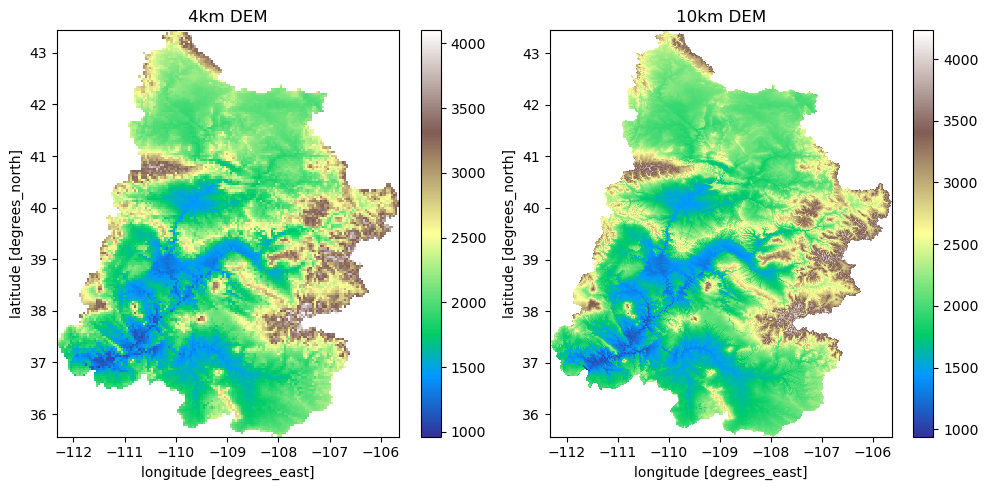

In [341]:
# plot 4km and 10km dem side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
dem_rxr_4km.where(dem_rxr_4km>0).plot(ax=ax[0], cmap='terrain')
ax[0].set_title('4km DEM')
dem_rxr_10km.where(dem_rxr_10km>0).plot(ax=ax[1],cmap='terrain')
ax[1].set_title('10km DEM')


# Streamflow Data

In [504]:
# open the streamflow data
column_to_skip = 'Unnamed: 21'
ucrb_naturalized_streamflow = pd.read_excel('./data/streamflow/NaturalFlows1906-2020_20221215.xlsx', sheet_name='TotalNaturalFlow'
                                            , skiprows=[0,3,4,5,1388,1389, 1390, 1391, 1392,1394,1394], index_col=0,
                                            usecols=lambda x: x != column_to_skip)
ucrb_gage_ids = ucrb_naturalized_streamflow.loc['USGS gauge name']
ucrb_naturalized_streamflow = ucrb_naturalized_streamflow.drop(['USGS gauge name'])
date_filter = (ucrb_naturalized_streamflow.index >= dt.datetime(2015,10,1)) & (ucrb_naturalized_streamflow.index < dt.datetime(2020,9,30))
ucrb_naturalized_streamflow = ucrb_naturalized_streamflow.loc[date_filter]

### Get gage locations

In [505]:
# colorado at Glenwood Springs, Gunnison at Grand Junction, Delores at Cisco
gage_ids = ['09124700', '09072500', '09180500']
points = [(38.45221354, -107.3481119,7149.30/3.28), (39.549982, -107.3208873,5720.71/3.28), (38.81054095, -109.2934493, 4092.35/3.28)]
gage_locs = gpd.GeoDataFrame(index=gage_ids, geometry=gpd.points_from_xy([x[1] for x in points], [x[0] for x in points], crs=4269))
# convert to 4326
gage_locs = gage_locs.to_crs(4326)



### Get basins containing gages

In [507]:

basins = []
generate_basins = False
if generate_basins:
    for j, basin in enumerate([gage_ids]):
        grid = Grid.from_raster('./data/basin_polygons/ucrb_dem_150m_4326.tif')
        dem = grid.read_raster('./data/basin_polygons/ucrb_dem_150m_4326.tif')
        # convert 
        # Condition DEM
        # ----------------------
        # Fill pits in DEM
        pit_filled_dem = grid.fill_pits(dem)

        # Fill depressions in DEM
        flooded_dem = grid.fill_depressions(pit_filled_dem)
            
        # Resolve flats in DEM
        inflated_dem = grid.resolve_flats(flooded_dem)

        # Determine D8 flow directions from DEM
        # ----------------------
        # Specify directional mapping
        dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
            
        # Compute flow directions
        # -------------------------------------
        fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

        # Calculate flow accumulation
        # --------------------------
        acc = grid.accumulation(fdir, dirmap=dirmap)

        # Delineate a catchment
        # Specify pour point
        x, y = gage_locs.geometry.x.loc[basin], gage_locs.geometry.y.loc[basin]

        # Snap pour point to high accumulation cell
        x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

        # Delineate the catchment
        catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                            xytype='coordinate')

        # Crop and plot the catchment
        # ---------------------------
        grid.clip_to(catch)
        # Create view
        catch_view = grid.view(catch, dtype=np.uint8)

        # Create a vector representation of the catchment mask
        shapes = grid.polygonize(catch_view)

        # Specify schema
        schema = {
                'geometry': 'Polygon',
                'properties': {'LABEL': 'float:16'}
        }

        # Write shapefile
        with fiona.open(f'./data/basin_polygons/gage_{basin}.json', 'w',
                        driver='GeoJSON',
                        crs=grid.crs.srs,
                        schema=schema) as c:
            i = 0
            for shape, value in shapes:
                rec = {}
                rec['geometry'] = shape
                rec['properties'] = {'LABEL' : str(value)}
                rec['id'] = str(i)
                c.write(rec)
                i += 1

2506.9827
2847.0784
3026.991


Text(205.39605560466356, 0.5, 'Latitude')

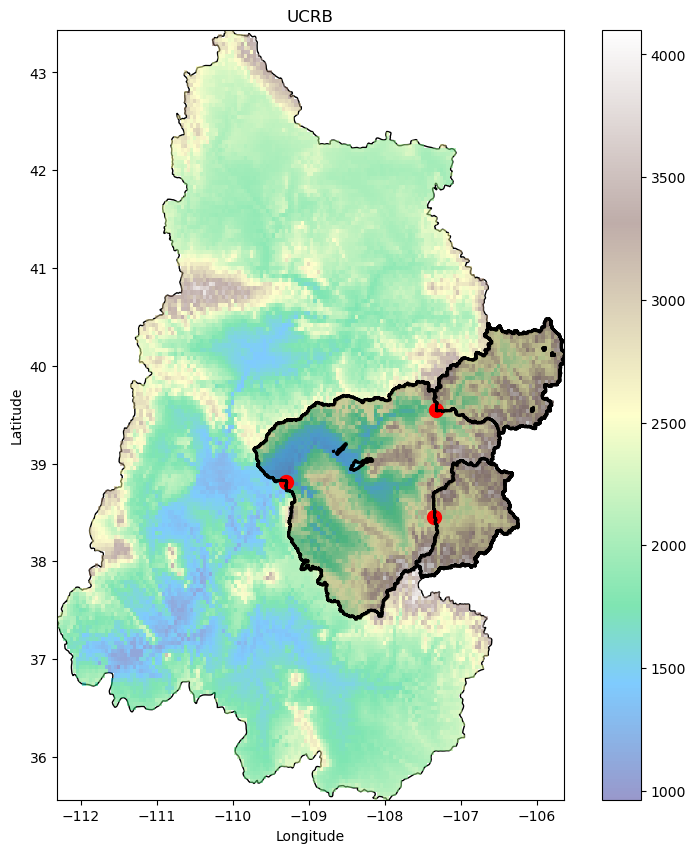

In [624]:
# plot the watersheds and the UCRB
fig, ax = plt.subplots(figsize=(10, 10))
ucrb_boundary.plot(ax=ax, color='none', edgecolor='black')
basin_areas = []
basin_areas_4326 = []
for gage_id in gage_ids[::-1]:
    gage = gpd.read_file(f'./data/basin_polygons/gage_{gage_id}.json')
    gage.plot(ax=ax, color='grey', alpha=0.8, edgecolor='k',lw=2)
    gage.boundary.plot(ax=ax, color='black', lw=2, zorder=3)
    # basin_areas.append(gage.to_crs(32613).area)
    # basin_areas_4326.append(gage.area)
    basin_elev = dem_rxr_4km.rio.clip(gage.geometry).squeeze()
    print(basin_elev.where(basin_elev>0).mean(dim=['x','y']).values)
# plotthe DEM
dem_rxr_4km.where(dem_rxr_4km>0).plot(ax=ax, cmap='terrain', alpha=0.5, zorder=1)
gage_locs.plot(ax=ax, color='red', label='Gage Locations', markersize=100, zorder=2)
ax.set_title('UCRB')
ax.set_xlabel('Longitude')   
ax.set_ylabel('Latitude')

### Spatial correlation between PRISM and IMERG (at 10km resolution)

c:\Users\dlhogan\miniforge3\envs\quals_env\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\dlhogan\miniforge3\envs\quals_env\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\dlhogan\miniforge3\envs\quals_env\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\dlhogan\miniforge3\envs\quals_env\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\dlhogan\miniforge3\envs\quals_env\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dty

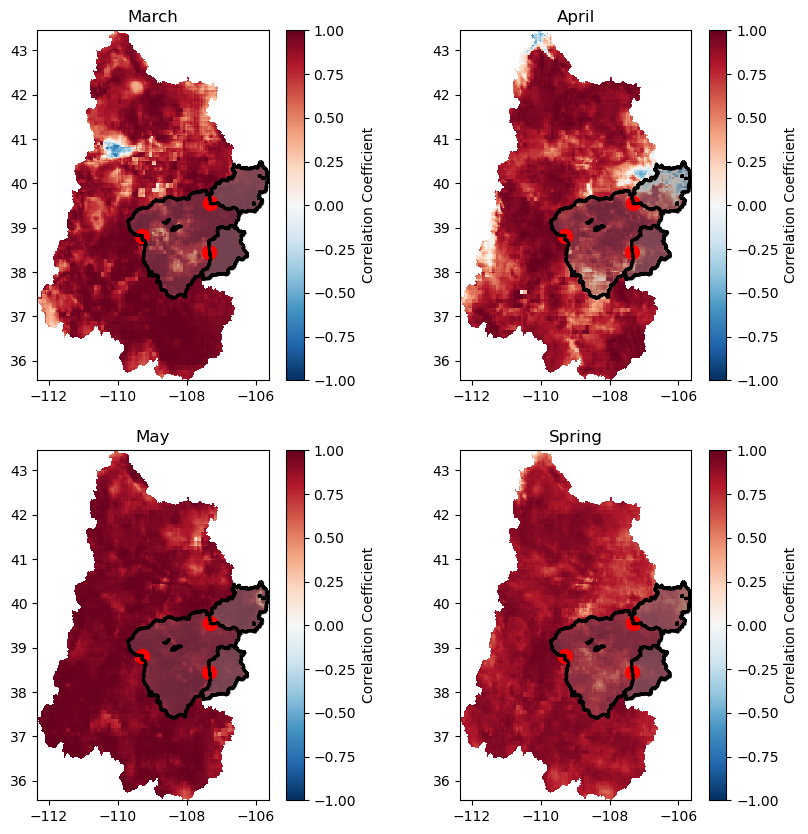

In [675]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
# plot correlation between elevation and ppt for imerg for each month
month = [3,4,5,None]
titles = ['March','April','May','Spring']
for i, axis in enumerate(axs.ravel()):
    ax = axs.ravel()[i]
    if month[i] == None:
        xr.corr(prism_10km_ppt.ppt, imerg.ppt, dim='month').plot(ax=ax, cmap='RdBu_r', vmin=-1, vmax=1, cbar_kwargs={'label': 'Correlation Coefficient'})
    else:
        xr.corr(prism_10km_ppt.ppt.where(imerg.month.dt.month==month[i],drop=True), imerg.ppt.where(imerg.month.dt.month==month[i],drop=True), dim='month').plot(ax=ax, cmap='RdBu_r', 
                                                                                                                                                                 vmin=-1, 
                                                                                                                                                                 vmax=1,
                                                                                                                                                                 cbar_kwargs={'label': 'Correlation Coefficient'})
    for gage_id in gage_ids[::-1]:
        gage = gpd.read_file(f'./data/basin_polygons/gage_{gage_id}.json')
        gage.plot(ax=ax, color='grey', alpha=0.3, edgecolor='k',lw=2)
        gage.boundary.plot(ax=ax, color='black', lw=2, zorder=3)
    gage_locs.plot(ax=ax, color='red', label='Gage Locations', markersize=100, zorder=1)
    ax.set_title(titles[i])
    # set the colorbar label 
    ax.set_ylabel('')
    ax.set_xlabel('')


In [613]:
# clip imerg and prism to the basins 
gage = gpd.read_file(f'./data/basin_polygons/gage_{gage_ids[0]}.json')
imerg_gage_gunnison = imerg.rio.clip(gage.geometry)
prism_4km_ppt_gage_gunnison = prism_4km_ppt.rio.clip(gage.geometry)
# replace negative values with nan
imerg_gage_gunnison = imerg_gage_gunnison.where(imerg_gage_gunnison > 0)
prism_4km_ppt_gage_gunnison = prism_4km_ppt_gage_gunnison.where(prism_4km_ppt_gage_gunnison > 0)

gage = gpd.read_file(f'./data/basin_polygons/gage_{gage_ids[1]}.json')
imerg_gage_colorado = imerg.rio.clip(gage.geometry)
prism_4km_ppt_gage_colorado = prism_4km_ppt.rio.clip(gage.geometry)
# replace negative values with nan
imerg_gage_colorado = imerg_gage_colorado.where(imerg_gage_colorado > 0)
prism_4km_ppt_gage_colorado = prism_4km_ppt_gage_colorado.where(prism_4km_ppt_gage_colorado > 0)

gage = gpd.read_file(f'./data/basin_polygons/gage_{gage_ids[2]}.json')
imerg_gage_cisco = imerg.rio.clip(gage.geometry)
prism_4km_ppt_gage_cisco = prism_4km_ppt.rio.clip(gage.geometry)
# replace negative values with nan
imerg_gage_cisco = imerg_gage_cisco.where(imerg_gage_cisco > 0)
prism_4km_ppt_gage_cisco = prism_4km_ppt_gage_cisco.where(prism_4km_ppt_gage_cisco > 0)
# recompute the fractional area for each basin
# calculate the area of each pixel
# calculate the total area
total_area = prism_4km_ppt_gage_gunnison['area'].sum(dim=['x','y'])
# calculate the fractional area
prism_4km_ppt_gage_gunnison['fractional_area'] = prism_4km_ppt_gage_gunnison['area'] / total_area

# calculate the area of each pixel
# calculate the total area
total_area = prism_4km_ppt_gage_colorado['area'].sum(dim=['x','y'])
# calculate the fractional area
prism_4km_ppt_gage_colorado['fractional_area'] = prism_4km_ppt_gage_colorado['area'] / total_area

# calculate the area of each pixel
# calculate the total area
total_area = prism_4km_ppt_gage_cisco['area'].sum(dim=['x','y'])
# calculate the fractional area
prism_4km_ppt_gage_cisco['fractional_area'] = prism_4km_ppt_gage_cisco['area'] / total_area


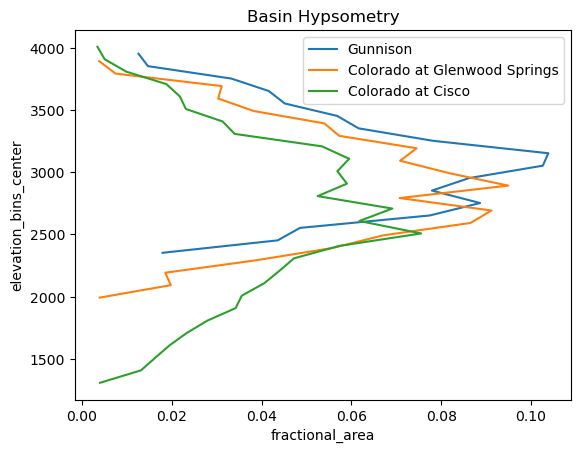

In [618]:
# groupby elevation bins and plot area fractions   
fig, ax = plt.subplots()
binned_gunnison = prism_4km_ppt_gage_gunnison.groupby_bins('elevation', bins=np.arange(prism_4km_ppt_gage_gunnison.elevation.min(),prism_4km_ppt_gage_gunnison.elevation.max(),100)).sum()
(binned_gunnison.fractional_area).plot(y='elevation_bins', label='Gunnison', ax=ax)
binned_colorado = prism_4km_ppt_gage_colorado.groupby_bins('elevation', bins=np.arange(prism_4km_ppt_gage_colorado.elevation.min(),prism_4km_ppt_gage_colorado.elevation.max(),100)).sum()
(binned_colorado.fractional_area).plot(y='elevation_bins', label='Colorado at Glenwood Springs', ax=ax)
binned_cisco = prism_4km_ppt_gage_cisco.groupby_bins('elevation', bins=np.arange(prism_4km_ppt_gage_cisco.elevation.min(),prism_4km_ppt_gage_cisco.elevation.max(),100)).sum()
(binned_cisco.fractional_area).plot(y='elevation_bins', label='Colorado at Cisco', ax=ax)
ax.set_title('Basin Hypsometry')
ax.legend()


In [549]:
# compute spring sum for each year
imerg_gage_gunnison_spring_sum = imerg_gage_gunnison.ppt.groupby('month.year').sum()
prism_4km_ppt_gage_gunnison_spring_sum = prism_4km_ppt_gage_gunnison.ppt.groupby('month.year').sum()
imerg_gage_colorado_spring_sum = imerg_gage_colorado.ppt.groupby('month.year').sum()
prism_4km_ppt_gage_colorado_spring_sum = prism_4km_ppt_gage_colorado.ppt.groupby('month.year').sum()
imerg_gage_cisco_spring_sum = imerg_gage_cisco.ppt.groupby('month.year').sum()
prism_4km_ppt_gage_cisco_spring_sum = prism_4km_ppt_gage_cisco.ppt.groupby('month.year').sum()

# replace 0 with nan
imerg_gage_gunnison_spring_sum = imerg_gage_gunnison_spring_sum.where(imerg_gage_gunnison_spring_sum>0, np.nan)
prism_4km_ppt_gage_gunnison_spring_sum = prism_4km_ppt_gage_gunnison_spring_sum.where(prism_4km_ppt_gage_gunnison_spring_sum>0, np.nan)
imerg_gage_colorado_spring_sum = imerg_gage_colorado_spring_sum.where(imerg_gage_colorado_spring_sum>0, np.nan)
prism_4km_ppt_gage_colorado_spring_sum = prism_4km_ppt_gage_colorado_spring_sum.where(prism_4km_ppt_gage_colorado_spring_sum>0, np.nan)
imerg_gage_cisco_spring_sum = imerg_gage_cisco_spring_sum.where(imerg_gage_cisco_spring_sum>0, np.nan)
prism_4km_ppt_gage_cisco_spring_sum = prism_4km_ppt_gage_cisco_spring_sum.where(prism_4km_ppt_gage_cisco_spring_sum>0, np.nan)


In [550]:
# compute basin mean ppt for each basin
imerg_gage_gunnison_mean = imerg_gage_gunnison_spring_sum.mean(dim=['x','y'])
prism_4km_ppt_gage_gunnison_mean = prism_4km_ppt_gage_gunnison_spring_sum.mean(dim=['x','y'])
imerg_gage_colorado_mean = imerg_gage_colorado_spring_sum.mean(dim=['x','y'])
prism_4km_ppt_gage_colorado_mean = prism_4km_ppt_gage_colorado_spring_sum.mean(dim=['x','y'])
imerg_gage_cisco_mean = imerg_gage_cisco_spring_sum.mean(dim=['x','y'])
prism_4km_ppt_gage_cisco_mean = prism_4km_ppt_gage_cisco_spring_sum.mean(dim=['x','y'])


### Calculate streamflow volumes

In [551]:
selected_basin_df = ucrb_naturalized_streamflow[gage_ids]
selected_basin_df.index = pd.to_datetime(ucrb_naturalized_streamflow.index)
# convert acre-feet to m^3
selected_basin_df = selected_basin_df * 1233.48
# normalize by basin area
for i, basin_area in enumerate(basin_areas):
    selected_basin_df[gage_ids[i]] = selected_basin_df[gage_ids[i]] / basin_area.values[0] * 1000
# Calculate AMJJ streamflow - i.e. melt season streamflow
amjj_streamflow_total = selected_basin_df[gage_ids][selected_basin_df[gage_ids].index.month.isin([4,5,6,7])]
# groupby year and sum
amjj_streamflow_total = amjj_streamflow_total.groupby(amjj_streamflow_total.index.year).sum()

# add a water year column and calculate water year streamflow
selected_basin_df['water_year'] = selected_basin_df.index.year.where(selected_basin_df.index.month < 10, selected_basin_df.index.year+1)
wy_streamflow_total = selected_basin_df[gage_ids].groupby(selected_basin_df['water_year']).sum()



Text(0, 0.5, 'Area Normalized Streamflow (mm)')

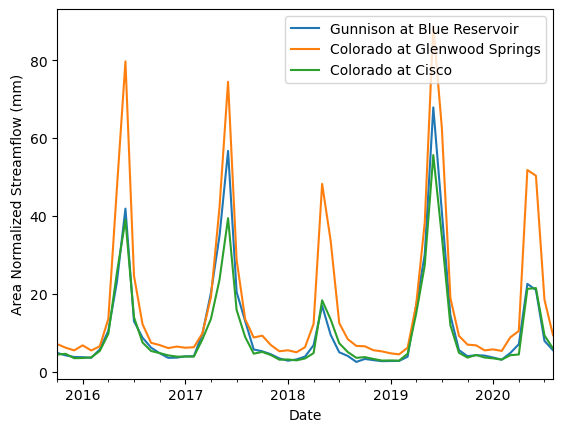

In [572]:
selected_basin_df[gage_ids].plot()
plt.legend(['Gunnison at Blue Reservoir', 'Colorado at Glenwood Springs',  'Colorado at Cisco'])
plt.xlabel('Date')
plt.ylabel('Area Normalized Streamflow (mm)')

0.16241176727559922
MAE for precip in Gunnison WY Streamflow: 40.13055419921875
RMSE for precip in Gunnison WY Streamflow: 45.713584899902344
0.13925967691454974
0.13744844285000057
MAE for precip in Gunnison AMJJ Streamflow: 40.13055419921875
RMSE for precip in Gunnison AMJJ Streamflow: 45.713584899902344
0.1040276693273943
0.0884513459816078
MAE for precip in Colorado WY Streamflow: 54.16020584106445
RMSE for precip in Colorado WY Streamflow: 55.162872314453125
0.04175901372806929
0.08425293341461862
MAE for precip in Colorado AMJJ Streamflow: 54.16020584106445
RMSE for precip in Colorado AMJJ Streamflow: 55.162872314453125
0.03852620037588259
0.09147282054147456
MAE for precip in Cisco WY Streamflow: 25.30673599243164
RMSE for precip in Cisco WY Streamflow: 29.805639266967773
0.05775000208658132
0.06167822190651844
MAE for precip in Cisco AMJJ Streamflow: 25.30673599243164
RMSE for precip in Cisco AMJJ Streamflow: 29.805639266967773
0.03337427014389947


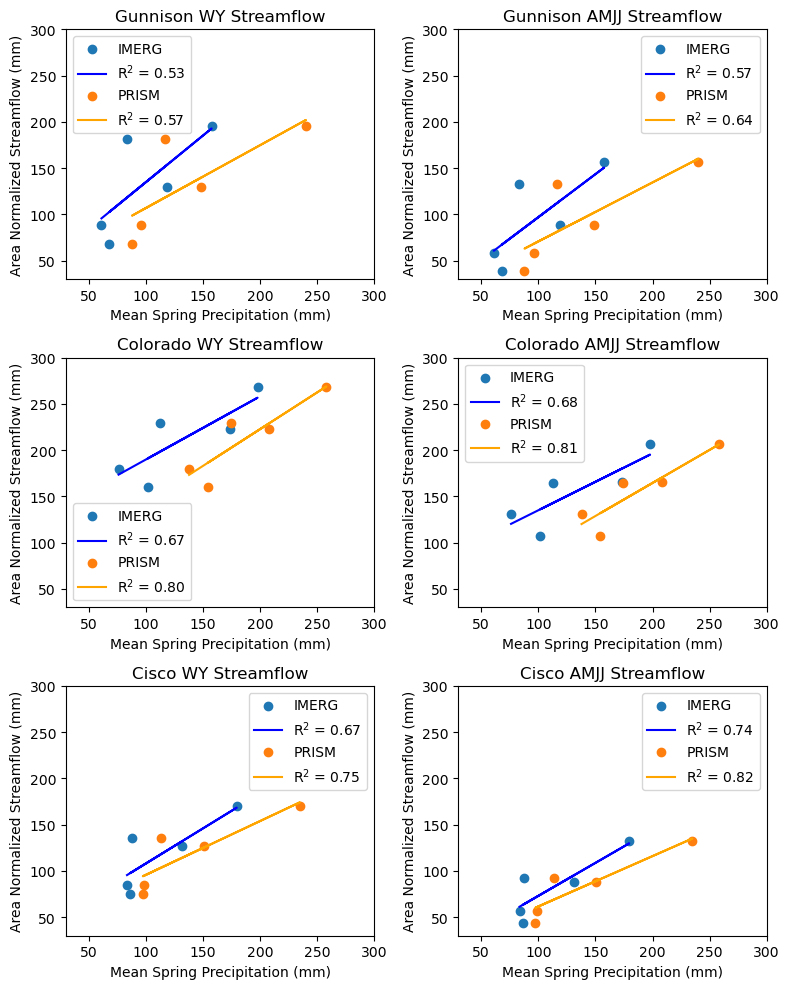

In [667]:
fig, axs = plt.subplots(3,2, figsize=(8,10), tight_layout=True,)
imerg_data = [imerg_gage_gunnison_mean, imerg_gage_gunnison_mean, imerg_gage_colorado_mean,
                imerg_gage_colorado_mean, imerg_gage_cisco_mean, imerg_gage_cisco_mean]
prism_data = [prism_4km_ppt_gage_gunnison_mean, prism_4km_ppt_gage_gunnison_mean, prism_4km_ppt_gage_colorado_mean,
                prism_4km_ppt_gage_colorado_mean, prism_4km_ppt_gage_cisco_mean, prism_4km_ppt_gage_cisco_mean]
streamflow_data = [wy_streamflow_total['09124700'], amjj_streamflow_total['09124700'],
                    wy_streamflow_total['09072500'], amjj_streamflow_total['09072500'],
                    wy_streamflow_total['09180500'], amjj_streamflow_total['09180500']]
titles = ['Gunnison WY Streamflow', 'Gunnison AMJJ Streamflow', 'Colorado WY Streamflow', 'Colorado AMJJ Streamflow', 'Cisco WY Streamflow', 'Cisco AMJJ Streamflow']
for i, ax in enumerate(axs.flatten()):
    # plot scatter
    ax.scatter(imerg_data[i], streamflow_data[i], label='IMERG')
    # plot trend line and label with r2
    slope, intercept, r_value, p_value, std_err = stats.linregress(imerg_data[i].values, streamflow_data[i].values.astype(float))
    print(p_value)
    # print the mean difference between imerg and prism)
    mae = np.mean(np.abs(imerg_data[i].values - prism_data[i].values))
    rmse = np.sqrt(np.mean((imerg_data[i].values - prism_data[i].values)**2))
    print(f'MAE for precip in {titles[i]}: {mae}')
    print(f'RMSE for precip in {titles[i]}: {rmse}')
    ax.plot(imerg_data[i], intercept + slope*imerg_data[i], 'b', label='R$^2$ = %0.2f' % (r_value**2))
    ax.scatter(prism_data[i], streamflow_data[i], label='PRISM')
    # plot trend line and label with r2
    slope, intercept, r_value, p_value, std_err = stats.linregress(prism_data[i].values, streamflow_data[i].values.astype(float))
    print(p_value)
    ax.plot(prism_data[i], intercept + slope*prism_data[i], 'orange', label='R$^2$ = %0.2f' % (r_value**2))
    ax.set_title(titles[i])
    ax.set_xlabel('Mean Spring Precipitation (mm)')
    ax.set_ylabel('Area Normalized Streamflow (mm)')
    ax.legend()
    ax.set_ylim(30,300)
    ax.set_xlim(30, 300)


In [ ]:
plt.scatter(imerg_gage_gunnison_mean, wy_streamflow_total['09124700'], label='IMERG ppt')
# plot trend line and label with r2
slope, intercept, r_value, p_value, std_err = stats.linregress(imerg_gage_gunnison_mean.values, wy_streamflow_total['09124700'].values.astype(float))
plt.plot(imerg_gage_gunnison_mean, intercept + slope*imerg_gage_gunnison_mean, 'b', label='R$^2$ = %0.2f' % r_value**2)
plt.scatter(prism_4km_ppt_gage_cisco_mean, wy_streamflow_total['09124700'], label='PRISM ppt')
# plot trend line and label with r2
slope, intercept, r_value, p_value, std_err = stats.linregress(prism_4km_ppt_gage_cisco_mean.values, wy_streamflow_total['09124700'].values.astype(float))
plt.plot(prism_4km_ppt_gage_cisco_mean, intercept + slope*prism_4km_ppt_gage_cisco_mean, 'orange', label='R$^2$ = %0.2f' % r_value**2)

plt.xlabel('Mean Spring Precipitation (mm)')
plt.ylabel('Area Normalized Water Year Streamflow (mm)')
plt.legend()